## imports

In [1]:
import scipy.stats as st
import numpy as np
import h5py
import scipy.integrate as integrate
from numba import njit
import toyplot
from tqdm.auto import tqdm
from scipy.special import binom

## define useful functions

We'll use these later but don't worry about them now.

In [2]:
# things we'll need:

# because scipy.stats.binom is slow...
def poisson_pmf(k, lam):
    try:
        x = (lam**k) * np.exp(-1*lam) / np.math.factorial(k)
        return(x)
    except:
        return( np.nan )

@njit
def binom_jit(n,k,p,com):
    return(com*p**k*(1-p)**(n-k))

# full binomial function!
def binomial(n,k,p):
    com=binom(n,k)
    return(binom_jit(n,k,p,com))    
    
# get the combinations of different crossovers from n_1 and ali_size that would yield a given n_2
# (that is, the different ways hap1s can switch to hap0 and hap0s can switch to hap1 to give us n_2)
@njit
def get_combs(n_1,ali_size,n_2):
    zs = ali_size - n_1
    arr_ = np.zeros((n_1+1,zs+1),dtype=np.int64)
    for row in range(arr_.shape[0]):
        for col in range(arr_.shape[1]):
            arr_[row,col] = n_1 - row + col
    # top row is the number of n_1 that change to zero, bottom is number of zero that change to 1
    return(np.vstack(np.where(arr_ == n_2)).T)

# calculate the probability of switching to an n_2 value given an n_1 value, p_1, p_2, and aliquot size

def calc_n_2_prob(n_1, n_2, p_1, p_2, ali_size):
    sumprob_n_2 = 0.0
    for i in get_combs(n_1, ali_size, n_2):
        nstay = n_1 - i[0] # nstay is the number of n_1 that stay n_1... i[0] is the number that change!
        nchange = i[1]
        # prob that nstay ones _do_ stay at one
        p_nstay = binomial(k=nstay, n=n_1, p=(1-p_2)*(1-p_1)+(1-p_2)*p_1*(1-p_2)+p_2*p_1*p_2)
        # prob that nchange zeros _do_ change to one
        p_nchange = binomial(k=nchange, n=ali_size-n_1, p=p_2*(1-p_1)+p_2*p_1*(1-p_2)+(1-p_2)*p_1*p_2)
        
        sumprob_n_2 += p_nstay * p_nchange
    return(sumprob_n_2)

# Define a full model

## Make a pretend recombination map.

In [3]:
# define an arbitrary recombination map...

# class for making a continuous pdf
class my_pdf(st.rv_continuous):
    def _pdf(self,x):
        return (1+np.cos(12.58*x))  # Normalized over its range, in this case [0,1]
# define recombination map
my_cv = my_pdf(a=0, b=2, name='my_pdf')

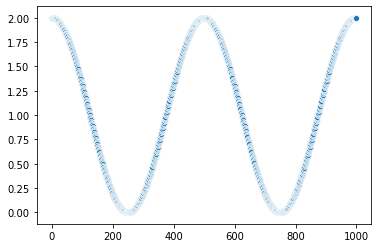

In [4]:
# here's our sample recombination map
sns.scatterplot(range(1000), 1+1*np.cos(12.58*np.linspace(0,1,num=1000)+0) );

#### Integrating from `alpha` to `beta` along the x-axis gives the bernoulli probability of a single recombination event landing between `alpha` and `beta`.

## Sequencing parameters

In [5]:
np.random.seed(123)

In [6]:
# the number of total aliquots sequenced -- used to calculate expected coverage per locus
nalis = 500

# number of gametes per aliquot
ali_size = 20

# number of loci per gamete that can be sequenced
nloci = 100

# sequencing effort. It's really just the number of random draws drom the pooled aliquots
nreads = 1e7

# from the poisson process of selecting a single locus from all
# pooled loci, which is a tiny probability that happens many times.
exp_cov_per_locus = nreads/nalis/nloci
exp_cov_per_locus 

200.0

## Biological parameters

In [7]:
# prob of a second crossover for each gamete. This is something defined by me. 
p_1 = 0.2

# first locus location (arbitrary choice for now)
alpha = 0.0

# second locus location (arbitrary choice for now)
beta = 0.32

# prob of a single crossover landing between alpha and beta values
# this is done by integrating between alpha and beta on the recomb map
p_2 = integrate.quad(lambda x: 1+np.cos(12.58*x), alpha, beta)[0]

## Likelihood calculation

In [8]:
# a pretend observation:
n_1_obs = 101 # number of 1-haplotype reads observed at locus Alpha
n_2_obs = 110 # number of 1-haplotype reads observed at locus Beta

In [9]:
# calculating likelihood
total_lik = 0
for n_1 in range(ali_size+1):
    for n_2 in range(ali_size+1):
        # prob of getting n_1 = n_1
        p_n_1 = binomial(k = n_1, n = ali_size, p = 0.5) # .5 prob of each alpha haplo being 1

        # prob of getting n_1_obs if n_1 = n_1?
        p_n_1_obs = poisson_pmf(k=n_1_obs, lam = (n_1/ali_size)*exp_cov_per_locus)

        # prob of n_2 being zero if n_1 is zero?
        p_n_2 = calc_n_2_prob(n_1,n_2,p_1,p_2,ali_size)

        # prob of getting n_2_obs if n_2 = n_2?
        p_n_2_obs = poisson_pmf(k=n_2_obs, lam = (n_2/ali_size)*exp_cov_per_locus)

        # total prob
        if 0 not in [p_n_1,p_n_1_obs,p_n_2,p_n_2_obs]:
            total_lik += np.exp( np.log(p_n_1)+np.log(p_n_1_obs)+np.log(p_n_2)+np.log(p_n_2_obs) )
        else:
            total_lik += 0
total_lik

0.00025155867195448503

# Now try to back-infer the recombination rate between two points in our simulated data.

#### I simulated 500 aliquots, each with 20 gametes, each with 100 loci. 1e7 total reads sequenced.

#### This was simulated under the recombination map defined at the top of the notebook.

In [10]:
haps = h5py.File("500ali_20gpa_1e7reads/haplotypes.hdf5",'r')

In [11]:
haps.keys() # aliquots

<KeysViewHDF5 ['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '22

In [12]:
haps['0'].keys() # loci

<KeysViewHDF5 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']>

In [13]:
np.array(haps['0']['0']) # sequenced haps at this locus

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1])

# Try to recover the recombination probability between two points from our simulated data.

## 1) Loci at an intermediate distance

### Choose our two loci, and look at the haplotype numbers at those loci across all 500 aliquots.

In [14]:
# what what is locus Alpha, how many hap1s do we observe there?
locusnumAlpha = 0 # locus location (out of 100)
n_1_obs_set = np.array([np.sum(np.array(haps[str(i)][str(locusnumAlpha)])) for i in range(500)])

# what what is locus Beta, how many hap1s do we observe there?
locusnumBeta = 36 # locus location (out of 100)
n_2_obs_set = np.array([np.sum(np.array(haps[str(i)][str(locusnumBeta)])) for i in range(500)])

# hold the haplotype data at these loci across all aliquots
n1n2 = np.vstack([n_1_obs_set,n_2_obs_set]).T

### Look at the "real" probability of recombination between these two loci.

In [15]:
# what is the true recombination rate between these two loci, used in simulation?
# this is the number we are trying to recover
p_2 = integrate.quad(lambda x: 1+np.cos(12.58*x), locusnumAlpha*0.01, locusnumBeta*0.01)[0]
p_2

0.2818446085683763

### Now, pretending we don't know the real answer, cycle through possible p_2 values, recording the likelihood of each.

In [16]:
# calculate the likelihood of observing n_1_obs hap1 reads at locus 1 and n_2_obs hap1 reads at locus 2
full_set = []
# test across values of p, finding which one yields the highest likelihood.
for p_2 in tqdm(np.linspace(0,1,num=101)):
    set1 = []
    for n_1_obs, n_2_obs in n1n2:
        total_lik = 0
        for n_1 in range(ali_size+1):
            for n_2 in range(ali_size+1):
                # prob of getting n_1 = 0
                p_n_1 = binomial(k = n_1, n = ali_size, p = 0.5) # .5 prob of each alpha haplo being 1

                # prob of getting n_1_obs if n_1 = 0?
                p_n_1_obs = poisson_pmf(k=n_1_obs, lam = (n_1/ali_size)*exp_cov_per_locus)

                # prob of n_2 being zero if n_1 is zero?
                p_n_2 = calc_n_2_prob(n_1,n_2,p_1,p_2,ali_size)

                # prob of getting n_2_obs if n_2 = 0?
                p_n_2_obs = poisson_pmf(k=n_2_obs, lam = (n_2/ali_size)*exp_cov_per_locus)

                # total prob
                if 0 not in [p_n_1,p_n_1_obs,p_n_2,p_n_2_obs]:
                    total_lik += np.exp( np.log(p_n_1)+np.log(p_n_1_obs)+np.log(p_n_2)+np.log(p_n_2_obs) )
                else:
                    total_lik += 0
        set1.append(np.log(total_lik))
    full_set.append(np.array(set1))
    
prob_sums = []
for i in full_set:
    prob_sums.append(np.sum(i[(~np.isnan(i)).astype(int) + (~np.isinf(i)).astype(int) == 2]))

canvas = toyplot.Canvas(width=300, height=300)
axes = canvas.cartesian()
mark = axes.scatterplot(np.linspace(0,1,num=101), np.array(prob_sums))

/Users/pmckenz1/miniconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


<svg class="toyplot-canvas-Canvas" height="300.0px" id="taac430ebae93482080020ffa3ba7f1cc" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 300.0 300.0" width="300.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0.0 0.5 1.0 -4000 -3900 -3800 -3700

### Predicted recombination rate (argmax of curve above):

In [17]:
# this should recover something close to our simulated p_2 value
np.linspace(0,1,num=101)[np.argmax(prob_sums)]

0.26

This is pretty close to our "real" recombination probability.

## 2) Choose a different two loci, this time with a much smaller probability of recombination:

In [24]:
# what what is locus Alpha, how many hap1s do we observe there?
locusnumAlpha = 29 # locus location
n_1_obs_set = np.array([np.sum(np.array(haps[str(i)][str(locusnumAlpha)])) for i in range(500)])

# what what is locus Beta, how many hap1s do we observe there?
locusnumBeta = 38 # locus location
n_2_obs_set = np.array([np.sum(np.array(haps[str(i)][str(locusnumBeta)])) for i in range(500)])

# hold the haplotype data at these loci across all aliquots
n1n2 = np.vstack([n_1_obs_set,n_2_obs_set]).T

### True recombination rate:

In [25]:
# what is the true recombination rate between these two loci, used in simulation?
# this is the number we are trying to recover
p_2 = integrate.quad(lambda x: 1+np.cos(12.58*x), locusnumAlpha*0.01, locusnumBeta*0.01)[0]
p_2

0.049262748915617965

### Back-infer the true recombination rate.

In [26]:
# calculate the likelihood of observing n_1_obs hap1 reads at locus 1 and n_2_obs hap1 reads at locus 2
full_set = []
# test across values of p, finding which one yields the highest likelihood.
for p_2 in tqdm(np.linspace(0,1,num=101)):
    set1 = []
    for n_1_obs, n_2_obs in n1n2:
        total_lik = 0
        for n_1 in range(ali_size+1):
            for n_2 in range(ali_size+1):
                # prob of getting n_1 = 0
                p_n_1 = binomial(k = n_1, n = ali_size, p = 0.5) # .5 prob of each alpha haplo being 1

                # prob of getting n_1_obs if n_1 = 0?
                p_n_1_obs = poisson_pmf(k=n_1_obs, lam = (n_1/ali_size)*exp_cov_per_locus)

                # prob of n_2 being zero if n_1 is zero?
                p_n_2 = calc_n_2_prob(n_1,n_2,p_1,p_2,ali_size)

                # prob of getting n_2_obs if n_2 = 0?
                p_n_2_obs = poisson_pmf(k=n_2_obs, lam = (n_2/ali_size)*exp_cov_per_locus)

                # total prob
                if 0 not in [p_n_1,p_n_1_obs,p_n_2,p_n_2_obs]:
                    total_lik += np.exp( np.log(p_n_1)+np.log(p_n_1_obs)+np.log(p_n_2)+np.log(p_n_2_obs) )
                else:
                    total_lik += 0
        set1.append(np.log(total_lik))
    full_set.append(np.array(set1))
    
prob_sums = []
for i in full_set:
    prob_sums.append(np.sum(i[(~np.isnan(i)).astype(int) + (~np.isinf(i)).astype(int) == 2]))

canvas = toyplot.Canvas(width=300, height=300)
axes = canvas.cartesian()
mark = axes.scatterplot(np.linspace(0,1,num=101), np.array(prob_sums))

/Users/pmckenz1/miniconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


<svg class="toyplot-canvas-Canvas" height="300.0px" id="t0ba3b2db9f9c4aa19dda3c0b1b9242f6" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 300.0 300.0" width="300.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0.0 0.5 1.0 -4100 -4000 -3900 -3800 -3700

In [27]:
# this should recover something close to our simulated p_2 value
np.linspace(0,1,num=101)[np.argmax(prob_sums)]

0.04

## 3) Finally, choose two loci that are far apart with high probability of recombination in-between.

In [37]:
# what what is locus Alpha, how many hap1s do we observe there?
locusnumAlpha = 3 # locus location
n_1_obs_set = np.array([np.sum(np.array(haps[str(i)][str(locusnumAlpha)])) for i in range(500)])

# what what is locus Beta, how many hap1s do we observe there?
locusnumBeta = 98 # locus location
n_2_obs_set = np.array([np.sum(np.array(haps[str(i)][str(locusnumBeta)])) for i in range(500)])

# hold the haplotype data at these loci across all aliquots
n1n2 = np.vstack([n_1_obs_set,n_2_obs_set]).T

In [38]:
# what is the true recombination rate between these two loci, used in simulation?
# this is the number we are trying to recover
p_2 = integrate.quad(lambda x: 1+np.cos(12.58*x), locusnumAlpha*0.01, locusnumBeta*0.01)[0]
p_2

0.9019685525171546

In [39]:
# calculate the likelihood of observing n_1_obs hap1 reads at locus 1 and n_2_obs hap1 reads at locus 2
full_set = []
# test across values of p, finding which one yields the highest likelihood.
for p_2 in tqdm(np.linspace(0,1,num=101)):
    set1 = []
    for n_1_obs, n_2_obs in n1n2:
        total_lik = 0
        for n_1 in range(ali_size+1):
            for n_2 in range(ali_size+1):
                # prob of getting n_1 = 0
                p_n_1 = binomial(k = n_1, n = ali_size, p = 0.5) # .5 prob of each alpha haplo being 1

                # prob of getting n_1_obs if n_1 = 0?
                p_n_1_obs = poisson_pmf(k=n_1_obs, lam = (n_1/ali_size)*exp_cov_per_locus)

                # prob of n_2 being zero if n_1 is zero?
                p_n_2 = calc_n_2_prob(n_1,n_2,p_1,p_2,ali_size)

                # prob of getting n_2_obs if n_2 = 0?
                p_n_2_obs = poisson_pmf(k=n_2_obs, lam = (n_2/ali_size)*exp_cov_per_locus)

                # total prob
                if 0 not in [p_n_1,p_n_1_obs,p_n_2,p_n_2_obs]:
                    total_lik += np.exp( np.log(p_n_1)+np.log(p_n_1_obs)+np.log(p_n_2)+np.log(p_n_2_obs) )
                else:
                    total_lik += 0
        set1.append(np.log(total_lik))
    full_set.append(np.array(set1))
    
prob_sums = []
for i in full_set:
    prob_sums.append(np.sum(i[(~np.isnan(i)).astype(int) + (~np.isinf(i)).astype(int) == 2]))

canvas = toyplot.Canvas(width=300, height=300)
axes = canvas.cartesian()
mark = axes.scatterplot(np.linspace(0,1,num=101), np.array(prob_sums))

/Users/pmckenz1/miniconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


<svg class="toyplot-canvas-Canvas" height="300.0px" id="t68dd1904b8c445deb4c0afdd1fdfef56" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 300.0 300.0" width="300.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0.0 0.5 1.0 -4250 -4000 -3750 -3500

In [40]:
# this should recover something close to our simulated p_2 value
np.linspace(0,1,num=101)[np.argmax(prob_sums)]

0.85

Pretty close, but not exact.

## Next steps:

### * Three-locus case, where we calculate probabilities between 1) Alpha and Beta, 2) Beta and Gamma, and 3) Alpha and Gamma, then consolidate the information to make better estimates of the two rates.  
### * Make it faster...  
### * Power analysis with realistic parameters